In [ ]:
import tensorflow as tf

# Check GPU availability
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

GPU is available
TensorFlow version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Final Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow import keras
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.layers as ls
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical


In [ ]:
import os
from glob import glob
import pandas as pd

# Define the base directory containing the dataset
data_dir = '/content/Final Dataset'  # Adjust this path

# Collect all JPEG files in the directory and subdirectories
all_files = glob(f'{data_dir}/**/*.jpg', recursive=True)

# Filter to separate image and mask files
image_files = [f for f in all_files if '_mask' not in f]
mask_files = [f for f in all_files if '_mask' in f]

# Create a mapping from image files to mask files
image_to_mask = {image: image.replace('.jpg', '_mask.jpg') for image in image_files}

# Filter out image files that do not have a corresponding mask file
valid_image_files = [image for image in image_files if image_to_mask[image] in mask_files]
valid_mask_files = [image_to_mask[image] for image in valid_image_files]

# Create a DataFrame from the valid paths
df = pd.DataFrame({
    'img': valid_image_files,
    'msk': valid_mask_files
})

# Display the DataFrame and information about it
print(df.head())
print(f"Total valid image-mask pairs: {len(df)}")

# Optionally, you might want to shuffle the DataFrame if needed
df = df.sample(frac=1).reset_index(drop=True)

# Split the dataset into train, validation, and test sets
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=7747)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=7747)



                                                 img  \
0  /content/Final Dataset/Glioma_Tumor/G_191_SP_.jpg   
1  /content/Final Dataset/Glioma_Tumor/G_145_BR_.jpg   
2  /content/Final Dataset/Glioma_Tumor/G_108_HF_.jpg   
3    /content/Final Dataset/Glioma_Tumor/G_2_HF_.jpg   
4      /content/Final Dataset/Glioma_Tumor/G_147.jpg   

                                                 msk  
0  /content/Final Dataset/Glioma_Tumor/G_191_SP__...  
1  /content/Final Dataset/Glioma_Tumor/G_145_BR__...  
2  /content/Final Dataset/Glioma_Tumor/G_108_HF__...  
3  /content/Final Dataset/Glioma_Tumor/G_2_HF__ma...  
4  /content/Final Dataset/Glioma_Tumor/G_147_mask...  
Total valid image-mask pairs: 3139


In [ ]:
len(train_df)

2542

In [ ]:
def transformator(df, IMG_SIZE_TRAIN=(128, 128), BATCH_SIZE=64):
    img_datag = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    msk_datag = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.02,
        height_shift_range=0.02,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    img_generator = img_datag.flow_from_dataframe(
        df,
        x_col='img',
        class_mode=None,
        color_mode='rgb',
        target_size=IMG_SIZE_TRAIN,
        batch_size=BATCH_SIZE,
        seed=7747)

    msk_generator = msk_datag.flow_from_dataframe(
        df,
        x_col='msk',
        class_mode=None,
        color_mode='grayscale',
        target_size=IMG_SIZE_TRAIN,
        batch_size=BATCH_SIZE,
        seed=7747)

    while True:
        img_batch = img_generator.next()
        msk_batch = msk_generator.next()
        msk_batch = msk_batch[..., 0]  # Assuming single channel grayscale masks
        msk_batch = np.select(
            [msk_batch < 64, msk_batch < 128, msk_batch < 192, msk_batch <= 255],
            [0, 1, 2, 3], default=0)
        msk_batch = to_categorical(msk_batch, num_classes=4)

        # Debugging output
        #print("Batch shapes - Images: {}, Masks: {}".format(img_batch.shape, msk_batch.shape))

        if img_batch.shape[0] == BATCH_SIZE and msk_batch.shape[0] == BATCH_SIZE:
            yield (img_batch / 255.0, msk_batch)
        else:
            #print("Discarded a batch due to incorrect size.")
            continue

In [ ]:
# Model Architecture
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    conv = ls.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = ls.Activation('relu')(conv)
    conv = ls.Conv2D(filters, kernel_size, padding=padding)(conv)
    conv = ls.BatchNormalization(axis=3)(conv)
    conv = ls.Activation('relu')(conv)
    return conv

def encoder_block(x, filters, pool_size=(2, 2), pool_strides=(2, 2)):
    conv = conv_block(x, filters)
    pool = ls.MaxPooling2D(pool_size, strides=pool_strides)(conv)
    return conv, pool

def decoder_block(x, shortcut, filters, kernel_size=3, strides=2):
    up = ls.Conv2DTranspose(filters, (kernel_size, kernel_size), strides=(strides, strides), padding='same')(x)
    up = ls.UpSampling2D(size=(shortcut.shape[1] // up.shape[1], shortcut.shape[2] // up.shape[2]))(up)
    up = ls.concatenate([up, shortcut], axis=3)
    up = conv_block(up, filters)
    return up


In [ ]:
smooth = 100
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersec = K.sum(y_true * y_pred)
    mod_sum = K.sum(y_true) + K.sum(y_pred)

    return (2 * intersec + smooth) / (mod_sum + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersec = K.sum(y_true * y_pred)
    comb_area = K.sum(y_true + y_pred) - intersec

    return (intersec + smooth) / (comb_area + smooth)

def iou_loss(y_true, y_pred):
  return - iou(y_true, y_pred)

In [ ]:
inputs = ls.Input((128, 128, 3))

# Encoder path
conv1, pool1 = encoder_block(inputs, 32)
conv2, pool2 = encoder_block(pool1, 64)
conv3, pool3 = encoder_block(pool2, 128)
conv4, pool4 = encoder_block(pool3, 256)
conv5, pool5 = encoder_block(pool4, 512)
# New encoder layer
conv6, pool6 = encoder_block(pool5, 1024)

# Bottleneck
# Normally, this is the most complex part of the model, you might want to add additional convolutions here.

# Decoder path
# New decoder layer corresponding to the new encoder layer
up7 = decoder_block(pool6, conv5, 512)
up6 = decoder_block(up7, conv4, 256)
up7 = decoder_block(up6, conv3, 128)
up8 = decoder_block(up7, conv2, 64)
up9 = decoder_block(up8, conv1, 32)

output = ls.Conv2D(4, (1, 1), activation='softmax')(up9)  # Multi-class output layer
model = Model(inputs=[inputs], outputs=[output])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy",dice_coef,iou])


In [ ]:
data_train = transformator(train_df)
data_val = transformator(test_df)
steps_per_epoch = (len(train_df) / 64)

validation_steps = (len(val_df) / 64)

history = model.fit(
    data_train,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[ModelCheckpoint('unet_multi_class_segmentation.hdf5', verbose=1, save_best_only=True)],
    validation_data=data_val,
    validation_steps=validation_steps
)


Found 2542 validated image filenames.
Found 2542 validated image filenames.
Epoch 1/50
40/39 [==============================] - ETA: 0s - loss: 0.5181 - accuracy: 0.9286 - dice_coef: 0.6406 - iou: 0.4837Found 314 validated image filenames.
Found 314 validated image filenames.

Epoch 1: val_loss improved from inf to 4.53878, saving model to unet_multi_class_segmentation.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 67s 750ms/step - loss: 0.5181 - accuracy: 0.9286 - dice_coef: 0.6406 - iou: 0.4837 - val_loss: 4.5388 - val_accuracy: 0.9193 - val_dice_coef: 0.4097 - val_iou: 0.2576
Epoch 2/50
40/39 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9781 - dice_coef: 0.8398 - iou: 0.7247
Epoch 2: val_loss improved from 4.53878 to 0.45807, saving model to unet_multi_class_segmentation.hdf5
39/39 [==============================] - 28s 708ms/step - loss: 0.2091 - accuracy: 0.9781 - dice_coef: 0.8398 - iou: 0.7247 - val_loss: 0.4581 - val_accuracy: 0.9802 - val_dice_coef: 0.6427 - val_iou: 0.4735
Epoch 3/50
40/39 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9785 - dice_coef: 0.8976 - iou: 0.8143
Epoch 3: val_loss improved from 0.45807 to 0.21779, saving model to unet_multi_class_segmentation.hdf5
39/39 [==============================] - 30s 756ms/step - loss: 0.1463 - accuracy: 0.9785 - dice_coef: 0.8976 - iou: 0.814

In [ ]:
# Evaluation
data_test = transformator(test_df)
results = model.evaluate(data_test, steps=(len(test_df) / 32))
print("Test Accuracy: ", round(results[1], 3))



Found 314 validated image filenames.
Found 314 validated image filenames.
9/9 [==============================] - 6s 652ms/step - loss: 0.0228 - accuracy: 0.9938 - dice_coef: 0.9891 - iou: 0.9784
Test Accuracy:  0.994


1/1 [==============================] - 2s 2s/step


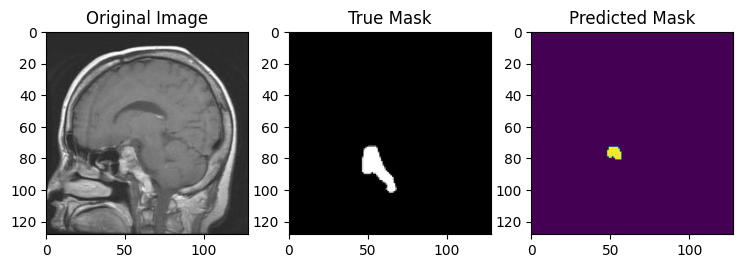

1/1 [==============================] - 0s 19ms/step


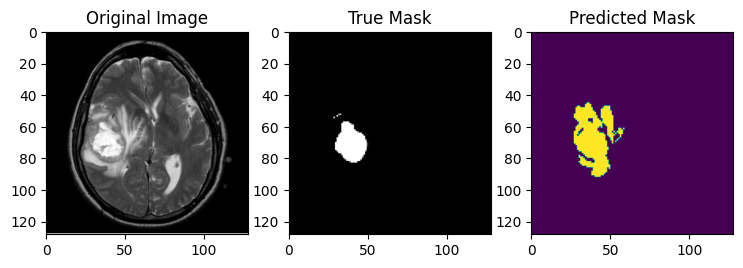

1/1 [==============================] - 0s 22ms/step


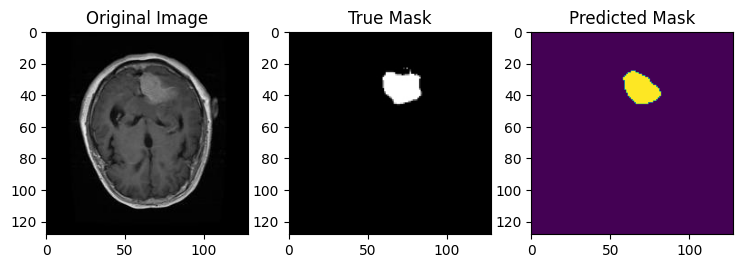

1/1 [==============================] - 0s 19ms/step


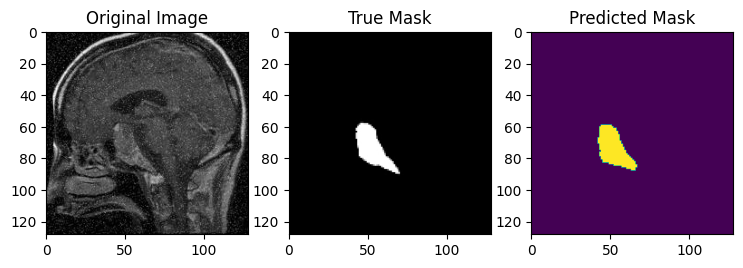

1/1 [==============================] - 0s 20ms/step


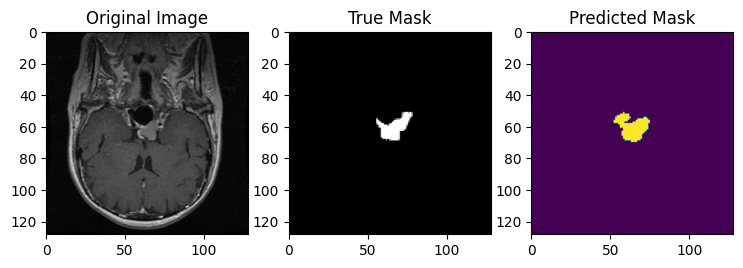

1/1 [==============================] - 0s 37ms/step


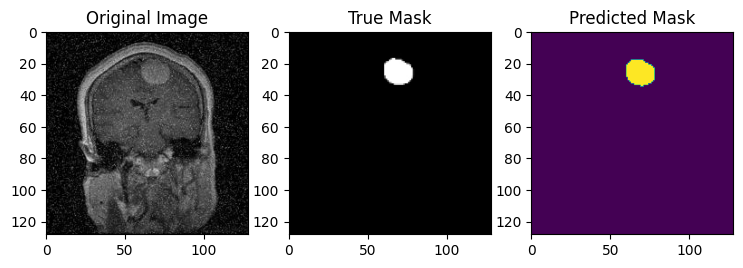

1/1 [==============================] - 0s 27ms/step


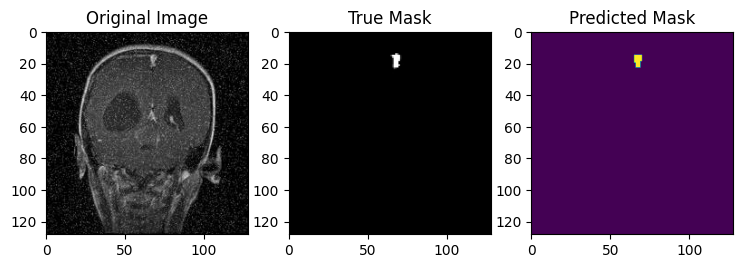

1/1 [==============================] - 0s 31ms/step


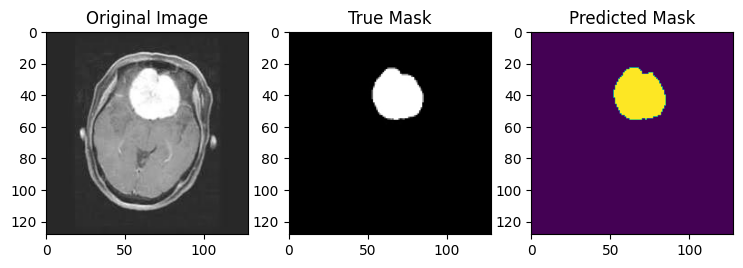

1/1 [==============================] - 0s 29ms/step


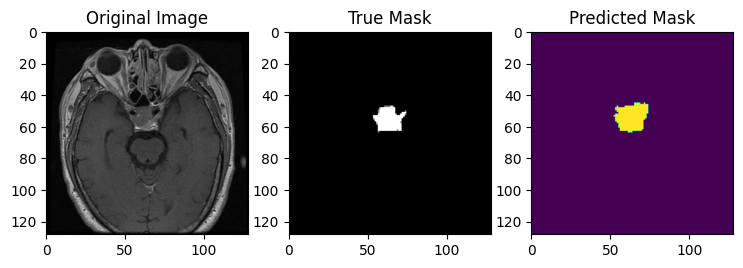

1/1 [==============================] - 0s 21ms/step


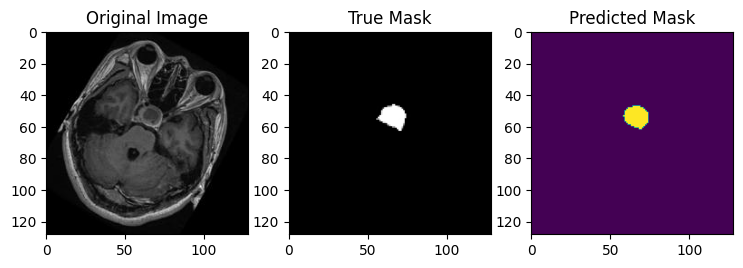

1/1 [==============================] - 0s 19ms/step


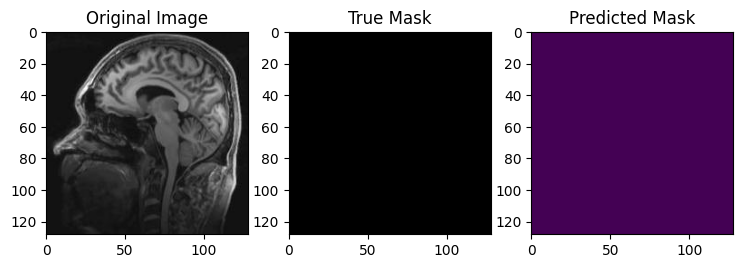

1/1 [==============================] - 0s 20ms/step


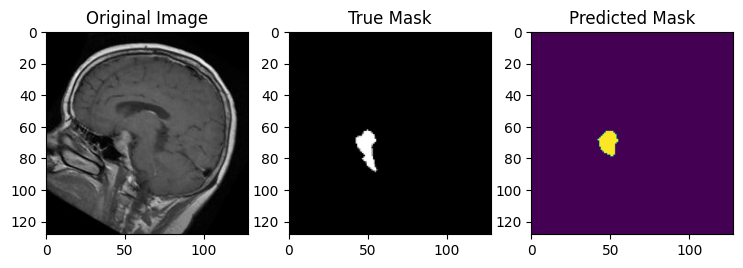

1/1 [==============================] - 0s 19ms/step


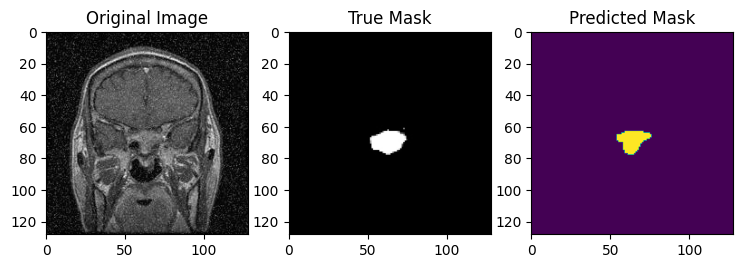

1/1 [==============================] - 0s 19ms/step


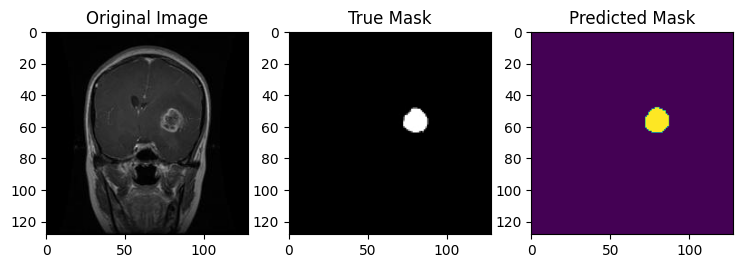

1/1 [==============================] - 0s 19ms/step


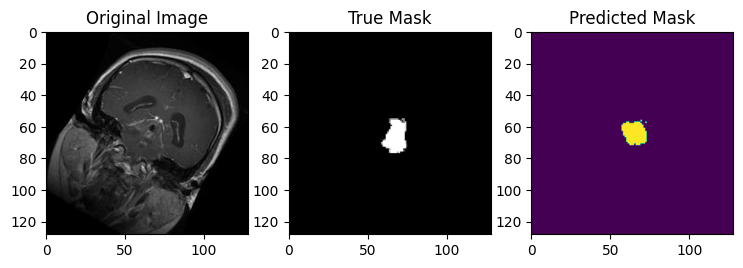

1/1 [==============================] - 0s 28ms/step


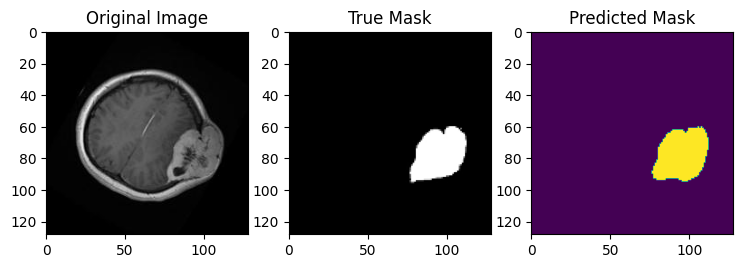

1/1 [==============================] - 0s 19ms/step


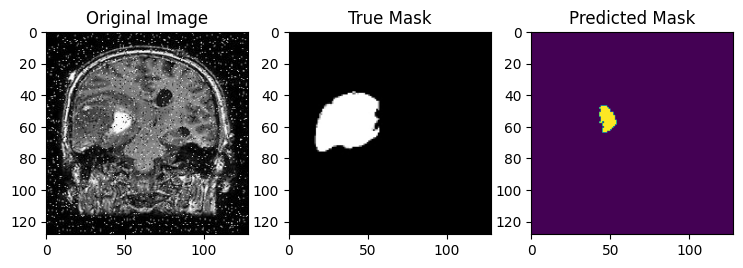

1/1 [==============================] - 0s 19ms/step


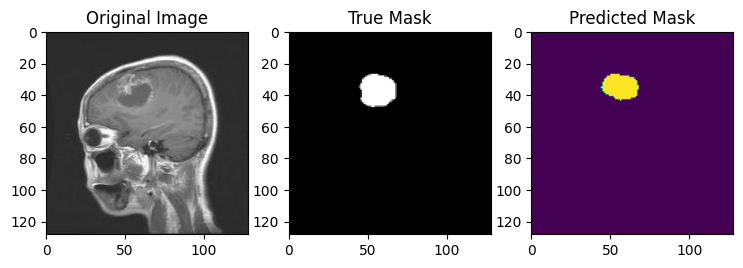

1/1 [==============================] - 0s 18ms/step


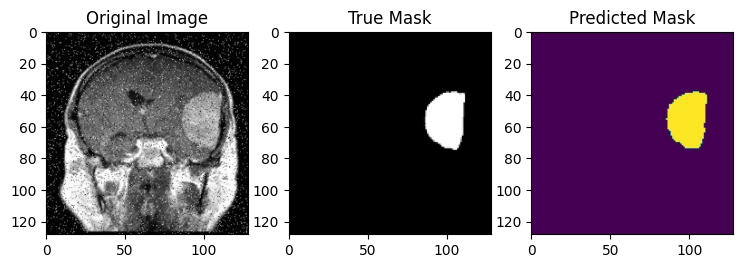

1/1 [==============================] - 0s 19ms/step


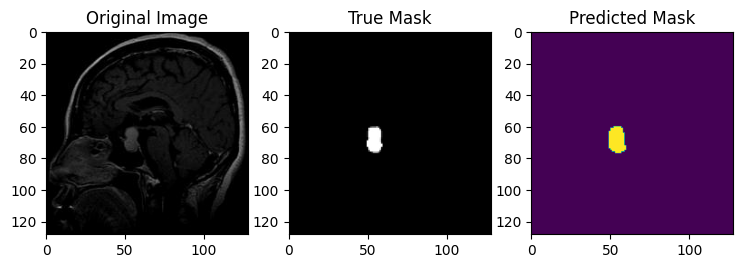

1/1 [==============================] - 0s 20ms/step


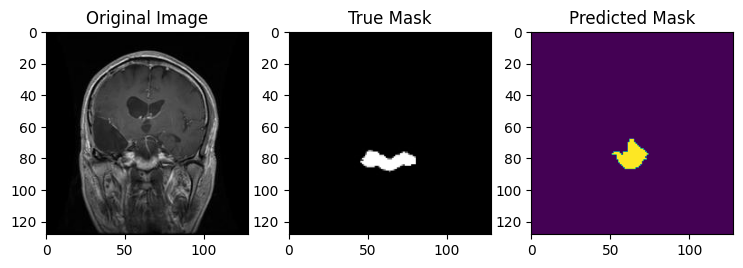

1/1 [==============================] - 0s 20ms/step


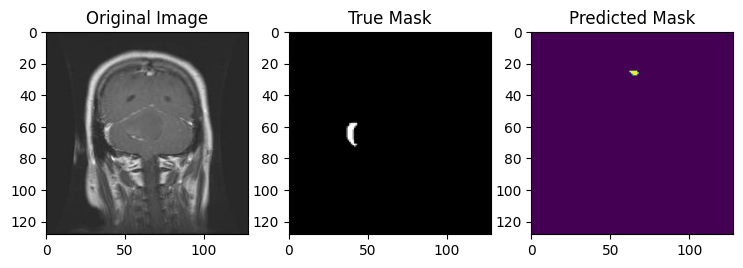

1/1 [==============================] - 0s 18ms/step


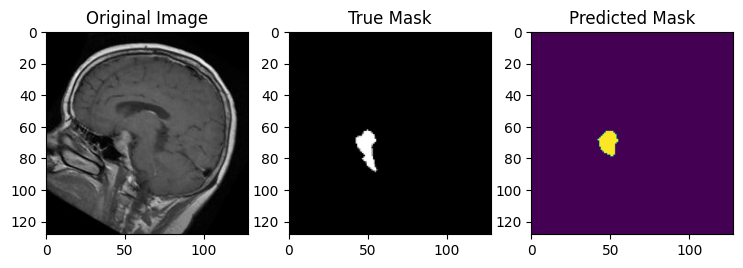

1/1 [==============================] - 0s 20ms/step


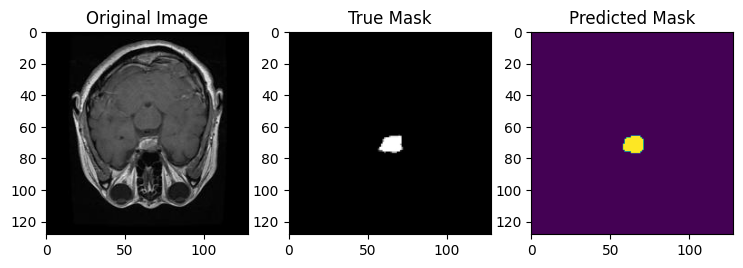

1/1 [==============================] - 0s 18ms/step


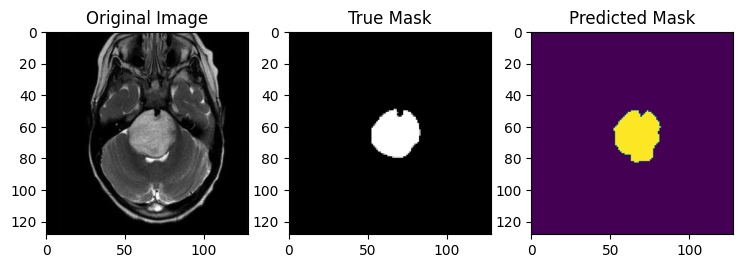

1/1 [==============================] - 0s 20ms/step


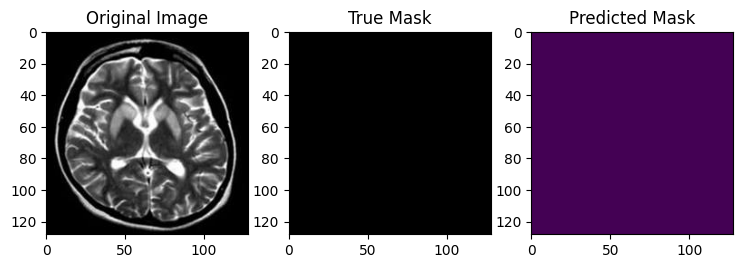

1/1 [==============================] - 0s 19ms/step


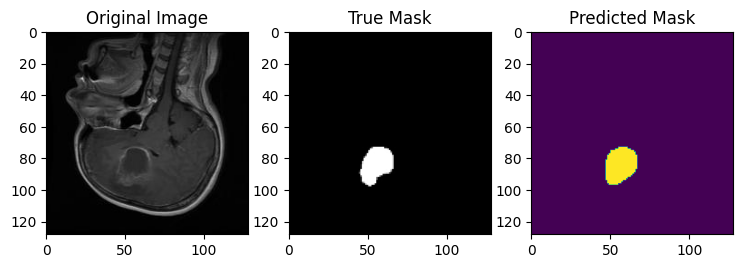

1/1 [==============================] - 0s 20ms/step


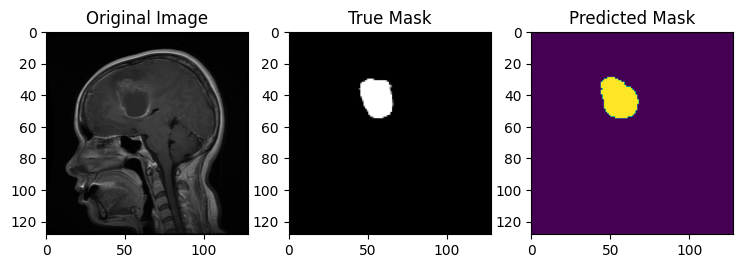

1/1 [==============================] - 0s 35ms/step


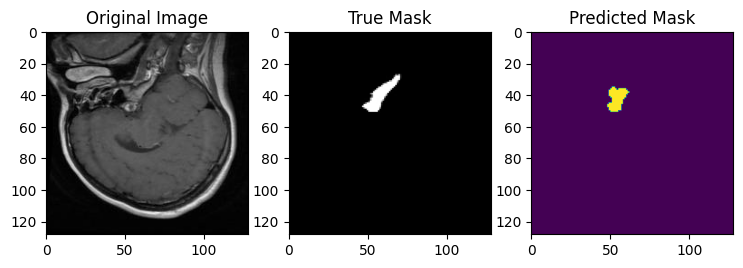

1/1 [==============================] - 0s 31ms/step


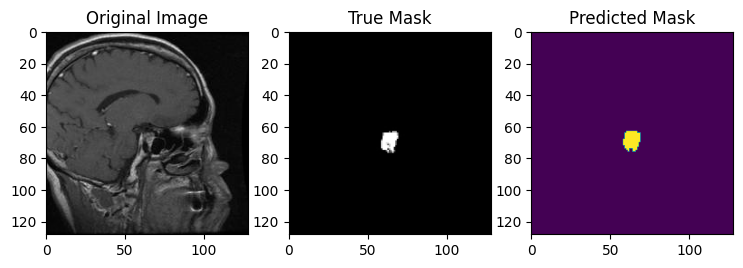

1/1 [==============================] - 0s 29ms/step


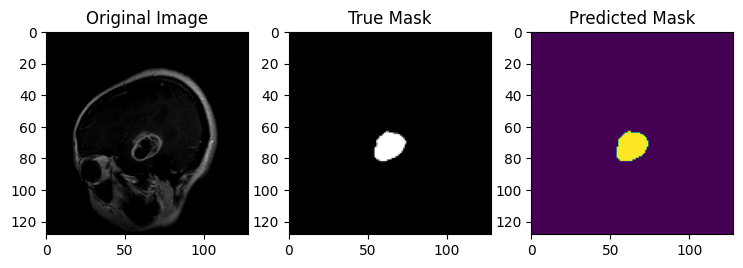

1/1 [==============================] - 0s 28ms/step


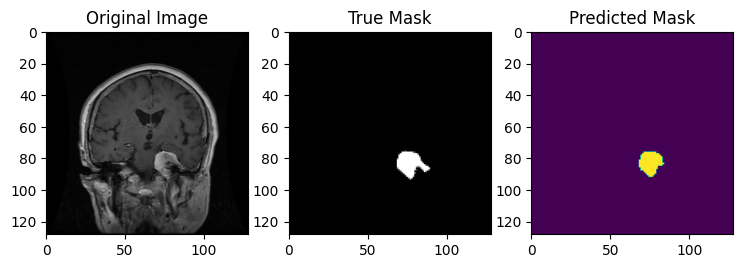

1/1 [==============================] - 0s 39ms/step


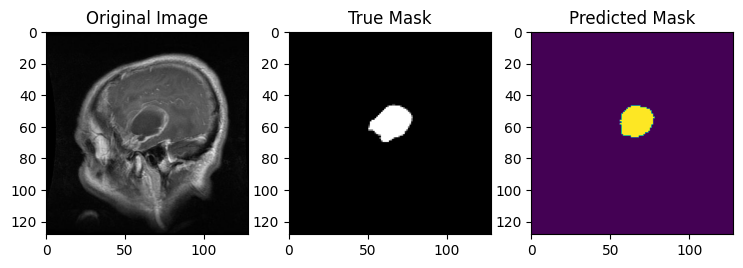

1/1 [==============================] - 0s 19ms/step


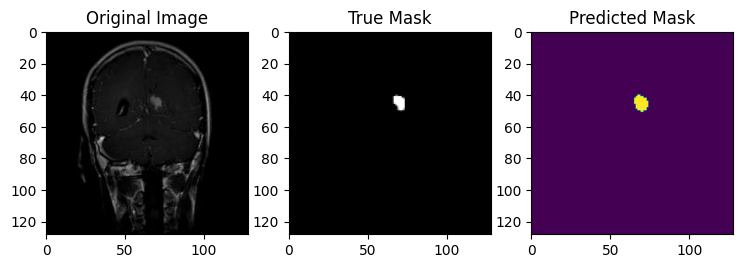

1/1 [==============================] - 0s 20ms/step


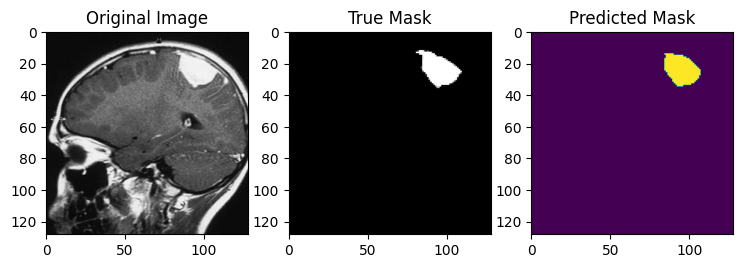

1/1 [==============================] - 0s 20ms/step


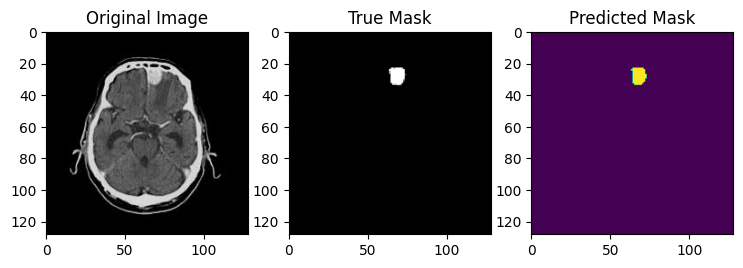

1/1 [==============================] - 0s 20ms/step


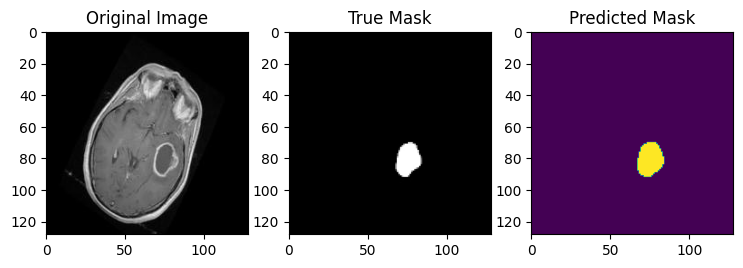

1/1 [==============================] - 0s 19ms/step


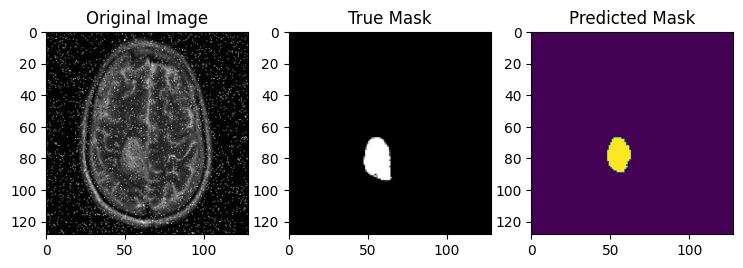

1/1 [==============================] - 0s 19ms/step


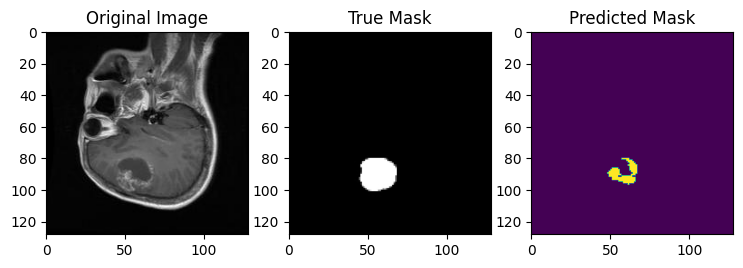

1/1 [==============================] - 0s 18ms/step


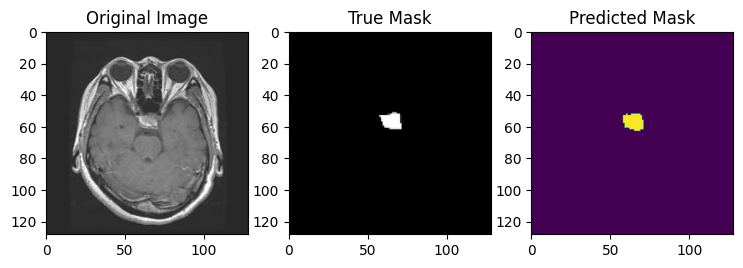

1/1 [==============================] - 0s 22ms/step


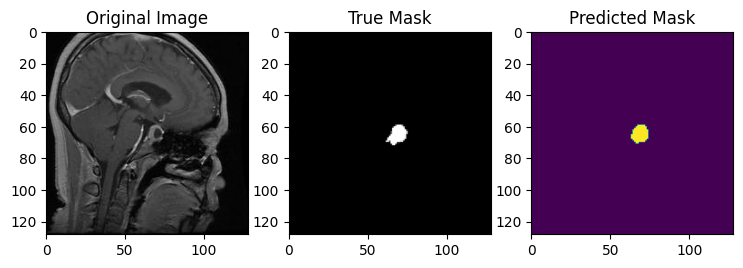

1/1 [==============================] - 0s 20ms/step


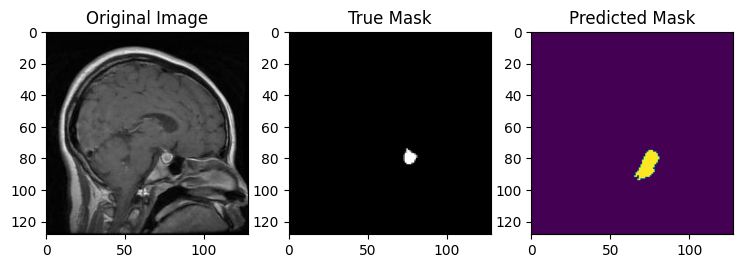

1/1 [==============================] - 0s 21ms/step


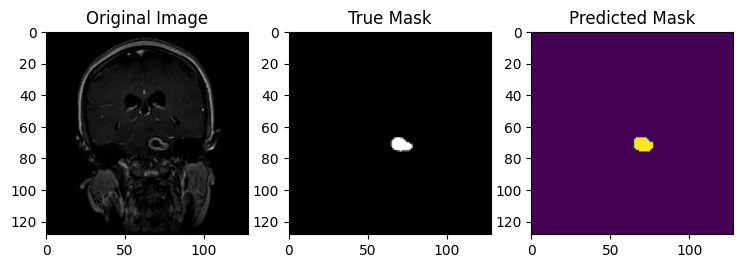

1/1 [==============================] - 0s 19ms/step


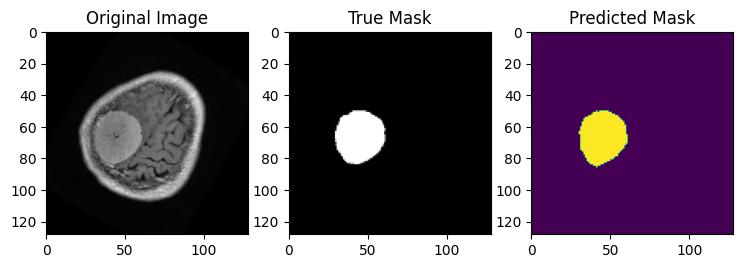

1/1 [==============================] - 0s 19ms/step


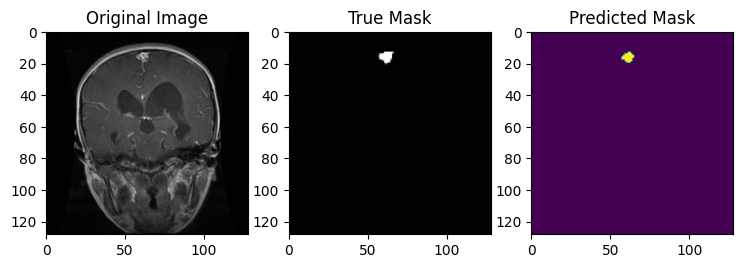

1/1 [==============================] - 0s 24ms/step


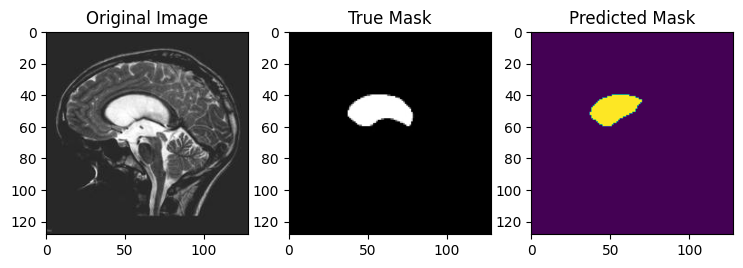

1/1 [==============================] - 0s 20ms/step


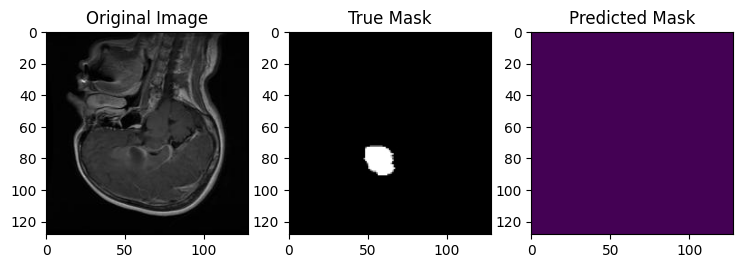

1/1 [==============================] - 0s 21ms/step


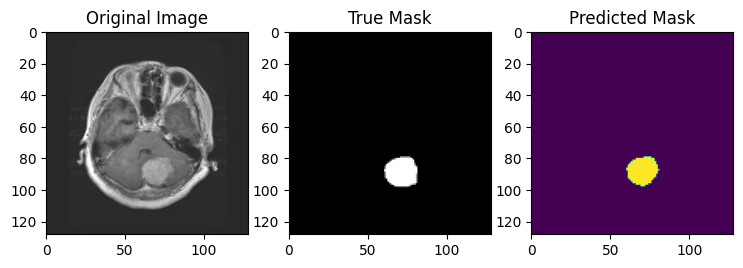

1/1 [==============================] - 0s 25ms/step


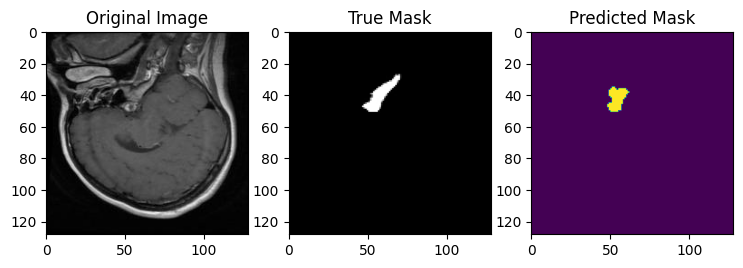

1/1 [==============================] - 0s 22ms/step


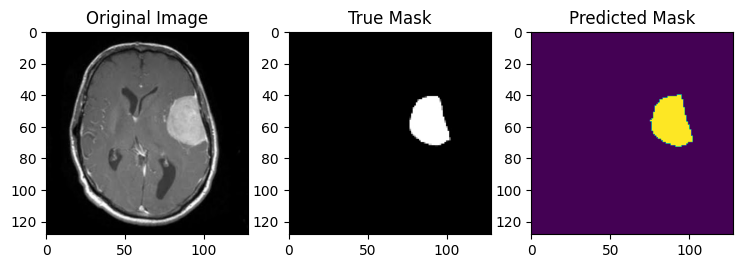

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

# Visualization of predictions
for i in range(50):
    index = np.random.randint(len(test_df))
    img_path = test_df.iloc[index]['img']
    msk_path = test_df.iloc[index]['msk']

    # Load and prepare the image
    img = cv2.imread(img_path)
    if img is None:
        #print(f"Failed to load image at {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color from BGR to RGB
    img_resized = cv2.resize(img, (128, 128))
    img_resized = img_resized / 255.0
    img_resized = img_resized[np.newaxis, :, :, :]  # Adding batch dimension

    # Model prediction
    pred = model.predict(img_resized)
    pred_mask = np.argmax(pred.squeeze(), axis=-1)  # Assuming pred is returned with a batch dimension

    # Load and prepare the mask
    true_mask = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    if true_mask is None:
        #print(f"Failed to load mask at {msk_path}")
        continue
    true_mask_resized = cv2.resize(true_mask, (128, 128))

    # Get the extent
    extent = (0, img_resized.shape[2], img_resized.shape[1], 0)  # (left, right, bottom, top)

    # Plotting
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 4, 1)
    plt.imshow(img, extent=extent)
    plt.title('Original Image')
    plt.subplot(1, 4, 2)
    plt.imshow(true_mask_resized, cmap='gray', extent=extent)
    plt.title('True Mask')
    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap='viridis', extent=extent)
    plt.title('Predicted Mask')
    plt.show()
